In [2]:
from dolfinx import fem, io, default_scalar_type, mesh
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import meshio
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages


In [65]:
mesh_file = "tensile_test_specimen2.msh"
domain, mesh_tags, facet_tags = io.gmshio.read_from_msh(mesh_file, MPI.COMM_WORLD, 0)

def FEM_Solution(domain, mesh_file, facet_tags, G, K) :
    # Import Geometry
    mesh = meshio.read(mesh_file)
    fdim = domain.topology.dim - 1
    domain.topology.create_connectivity(fdim, domain.topology.dim)
    V = fem.functionspace(domain, ("Lagrange", 1, (3,)))

    # Define Dirichlet Boundary Condition (Dirichelet BC is defined at the facet 3)
    b_D = fem.locate_dofs_topological(V, fdim, facet_tags.find(3))
    u_D = np.array([0, 0, 0], dtype=default_scalar_type)
    bc_D = fem.dirichletbc(u_D, b_D, V)

    # Define Neumann Boundary Condition
    T_neuman = fem.Constant(domain, default_scalar_type((106.26e6, 0, 0 )))
    ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags)

    # Define Weak form
    def epsilon(u):
        return ufl.sym(ufl.grad(u))  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)
    
    def sigma(u):
        return  (-2/3 * G + K) * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * G * epsilon(u)
    
    # Define Trial and Test Function
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    # Include Load into the system (the facet for Neumann Boundary is set at facet 4)
    f = fem.Constant(domain, default_scalar_type((0, 0, 0)))
    a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
    L = ufl.dot(f, v) * ufl.dx + ufl.dot(T_neuman, v) * ds(4)

    # Create Solver (Linear)
    problem = LinearProblem(a, L, bcs=[bc_D], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

    # Solve
    uh = problem.solve()
    
    # Post Processing (Retrieve solution in the dataset's domain)
    x_origin_sub = [20e-3, 100e-3]
    y_origin_sub = 10e-3

    domain_arr = domain.geometry.x
    print(domain_arr.shape)
    print(mesh.points.shape)
    subdomain_condition = (domain_arr[:, 0] >= x_origin_sub[0]) & (domain_arr[:, 0] <= x_origin_sub[1]) # Extract x-coordinates and apply condition
    
    num_dofs = V.dofmap.index_map.size_local
    uh_arr = uh.x.array[:].reshape((num_dofs, -1))
    def get_uh_with_coords(positions, features, query_positions) :
        """
        Return the features corresponding to the given query positions.

        Parameters:
        - positions: A 2D NumPy array of shape (n, d) representing the positions.
        - features: A NumPy array of shape (n, m) containing the features at each position.
        - query_positions: A 2D NumPy array of shape (k, d) representing the positions to query.

        Returns:
        - A NumPy array of shape (k, m) containing the features corresponding to the query positions.
        """
        # Find indices of the query positions in the positions array
        indices = np.where((positions[:, None] == query_positions).all(axis=2))[1]
        
        # Return the corresponding features
        return features[indices]

    # Get the subdomain for using with the data
    domain_sub = domain_arr[subdomain_condition]
    for cell in mesh.cells:
        if cell.type == 'triangle' :
            triangles = cell.data
    domain_sub[:, 0] -= x_origin_sub[0]
    domain_sub[:, 1] += y_origin_sub
    u_sub = uh_arr[subdomain_condition]

    return mesh.points, triangles, get_uh_with_coords(mesh.points, uh_arr, domain_arr), uh_arr, domain_sub, u_sub

Info    : Reading 'tensile_test_specimen2.msh'...
Info    : 28 entities
Info    : 467 nodes
Info    : 852 elements
Info    : Done reading 'tensile_test_specimen2.msh'


In [66]:
mesh_pos, node_connectivity, u, uh, domain_sub, u_sub = FEM_Solution(domain, mesh_file, facet_tags, 82e9, 120e9)

# with io.XDMFFile(domain.comm, "deformation_dogbone.xdmf", "w") as xdmf:
#     xdmf.write_mesh(domain)
#     u.name = "Deformation"
#     xdmf.write_function(u)


(467, 3)
(467, 3)


In [67]:
u

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.47458924e-06,  1.21675289e-06,  0.00000000e+00],
       ...,
       [ 2.15633987e-05,  9.65150992e-07,  0.00000000e+00],
       [ 4.07086718e-05, -1.02945004e-06,  0.00000000e+00],
       [ 4.75328073e-05,  5.83931027e-07,  0.00000000e+00]])

In [68]:
uh

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.18141392e-07, -4.31001650e-07,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 5.22784339e-05,  1.11517683e-06,  0.00000000e+00],
       [ 5.32004825e-05,  1.02067715e-06,  0.00000000e+00],
       [ 5.32033481e-05,  1.37996927e-06,  0.00000000e+00]])

In [44]:
domain.geometry.x

array([[ 0.        ,  0.0125    ,  0.        ],
       [ 0.00189932,  0.01370746,  0.        ],
       [ 0.        ,  0.015     ,  0.        ],
       ...,
       [ 0.09816987, -0.00816987,  0.        ],
       [ 0.1       , -0.0075    ,  0.        ],
       [ 0.1       , -0.01      ,  0.        ]])

In [54]:
domain.geometry.x[466]

array([ 0.1 , -0.01,  0.  ])

In [53]:
np.where((domain.geometry.x[:, None] == np.array([[0, 0, 0], [0.015, -0.01, 0],[0.1, -0.01, 0]])).all(axis=2))

(array([ 13,  95, 466]), array([0, 1, 2]))

In [33]:
mesh_pos

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.015     ,  0.        ],
       [ 0.015     , -0.01      ,  0.        ],
       ...,
       [ 0.04449352, -0.00825791,  0.        ],
       [ 0.07550405,  0.00825862,  0.        ],
       [ 0.08876786, -0.00456376,  0.        ]])

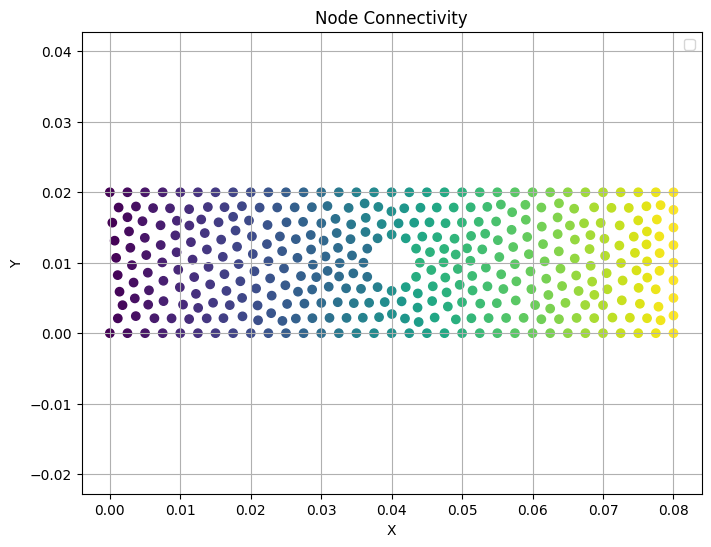

In [19]:
import matplotlib.pyplot as plt
import meshio

# Read the .msh file

# Get node coordinates
nodes = domain_sub[:, :2]  # Extract the x, y coordinates (for 2D)

# Get connectivity for triangular elements
triangles = node_connectivity

if triangles is None:
    raise ValueError("No triangular elements found in the mesh.")

# Plotting
plt.figure(figsize=(8, 6))

# Plot each triangle
# for triangle in triangles:
#     # Get the x and y coordinates of the nodes in this triangle
#     x = nodes[triangle, 0]
#     y = nodes[triangle, 1]
#     # Close the triangle by repeating the first node
#     x = list(x) + [x[0]]
#     y = list(y) + [y[0]]
#     plt.plot(x, y, 'k-', linewidth = 0.01)  # Draw the edges of the triangle

# Plot the nodes
plt.scatter(nodes[:, 0], nodes[:, 1], c=u_sub[:, 0])

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Node Connectivity")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()


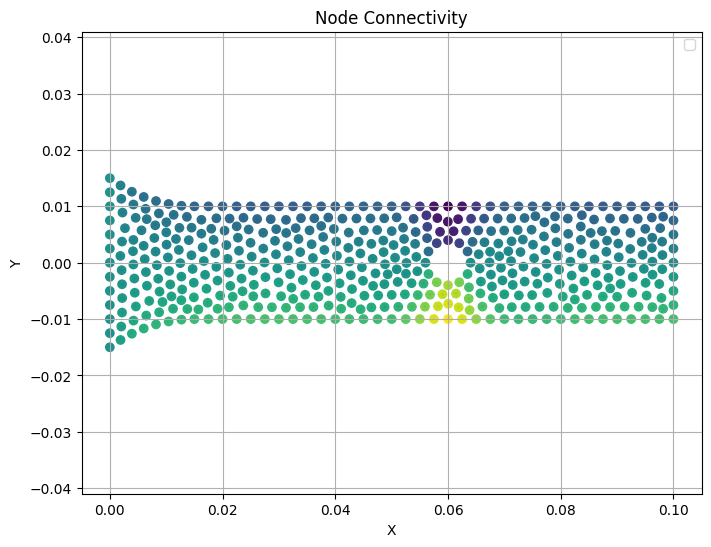

In [70]:
import matplotlib.pyplot as plt
import meshio

# Read the .msh file

# Get node coordinates
nodes = mesh_pos[:, :2]  # Extract the x, y coordinates (for 2D)

# Get connectivity for triangular elements
triangles = node_connectivity

if triangles is None:
    raise ValueError("No triangular elements found in the mesh.")

# Plotting
plt.figure(figsize=(8, 6))

# Plot each triangle
for triangle in triangles:
    # Get the x and y coordinates of the nodes in this triangle
    x = nodes[triangle, 0]
    y = nodes[triangle, 1]
    # Close the triangle by repeating the first node
    x = list(x) + [x[0]]
    y = list(y) + [y[0]]
    plt.plot(x, y, 'k-', linewidth = 0.01)  # Draw the edges of the triangle

# Plot the nodes
plt.scatter(nodes[:, 0], nodes[:, 1], c=u[:, 1])

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Node Connectivity")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()


In [131]:
a = np.sort(mesh.points, axis = 0)

In [130]:
b = np.sort(mesh_pos, axis = 0, )

In [133]:
sum(~(a == b))

array([0, 0, 0])

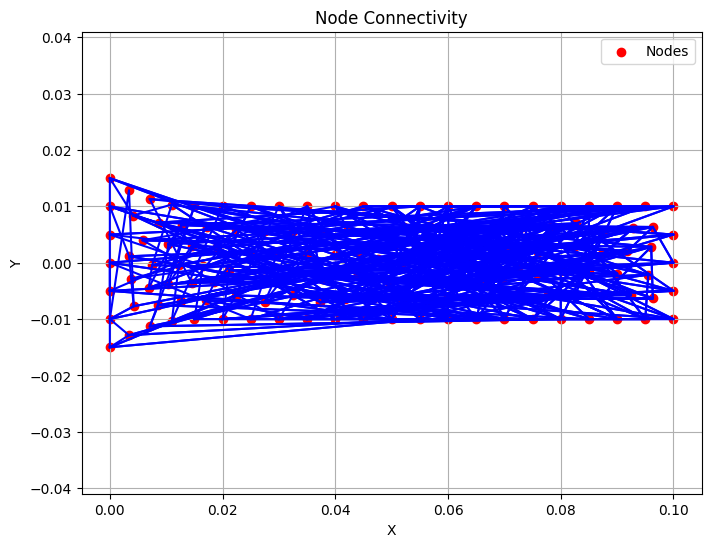

In [60]:
import matplotlib.pyplot as plt
import meshio

# Read the .msh file

# Get node coordinates
nodes = mesh_pos[:, :2]  # Extract the x, y coordinates (for 2D)

# Get connectivity for triangular elements
triangles = node_connectivity

if triangles is None:
    raise ValueError("No triangular elements found in the mesh.")

# Plotting
plt.figure(figsize=(8, 6))

# Plot each triangle
for triangle in triangles:
    # Get the x and y coordinates of the nodes in this triangle
    x = nodes[triangle, 0]
    y = nodes[triangle, 1]
    # Close the triangle by repeating the first node
    x = list(x) + [x[0]]
    y = list(y) + [y[0]]
    plt.plot(x, y, 'b-')  # Draw the edges of the triangle

# Plot the nodes
plt.scatter(nodes[:, 0], nodes[:, 1], c='red', label='Nodes')

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Node Connectivity")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import meshio

# Read the .msh file

# Get node coordinates
nodes = nodes[:, :2]  # Extract the x, y coordinates (for 2D)

# Get connectivity for triangular elements
triangles = node_connectivity

if triangles is None:
    raise ValueError("No triangular elements found in the mesh.")

# Plotting
plt.figure(figsize=(8, 6))

# Plot each triangle
for triangle in triangles:
    # Get the x and y coordinates of the nodes in this triangle
    x = nodes[triangle, 0]
    y = nodes[triangle, 1]
    # Close the triangle by repeating the first node
    x = list(x) + [x[0]]
    y = list(y) + [y[0]]
    plt.plot(x, y, 'b-')  # Draw the edges of the triangle

# Plot the nodes
plt.scatter(nodes[:, 0], nodes[:, 1], c='red', label='Nodes')

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Node Connectivity")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()


6.193448879410702e-05


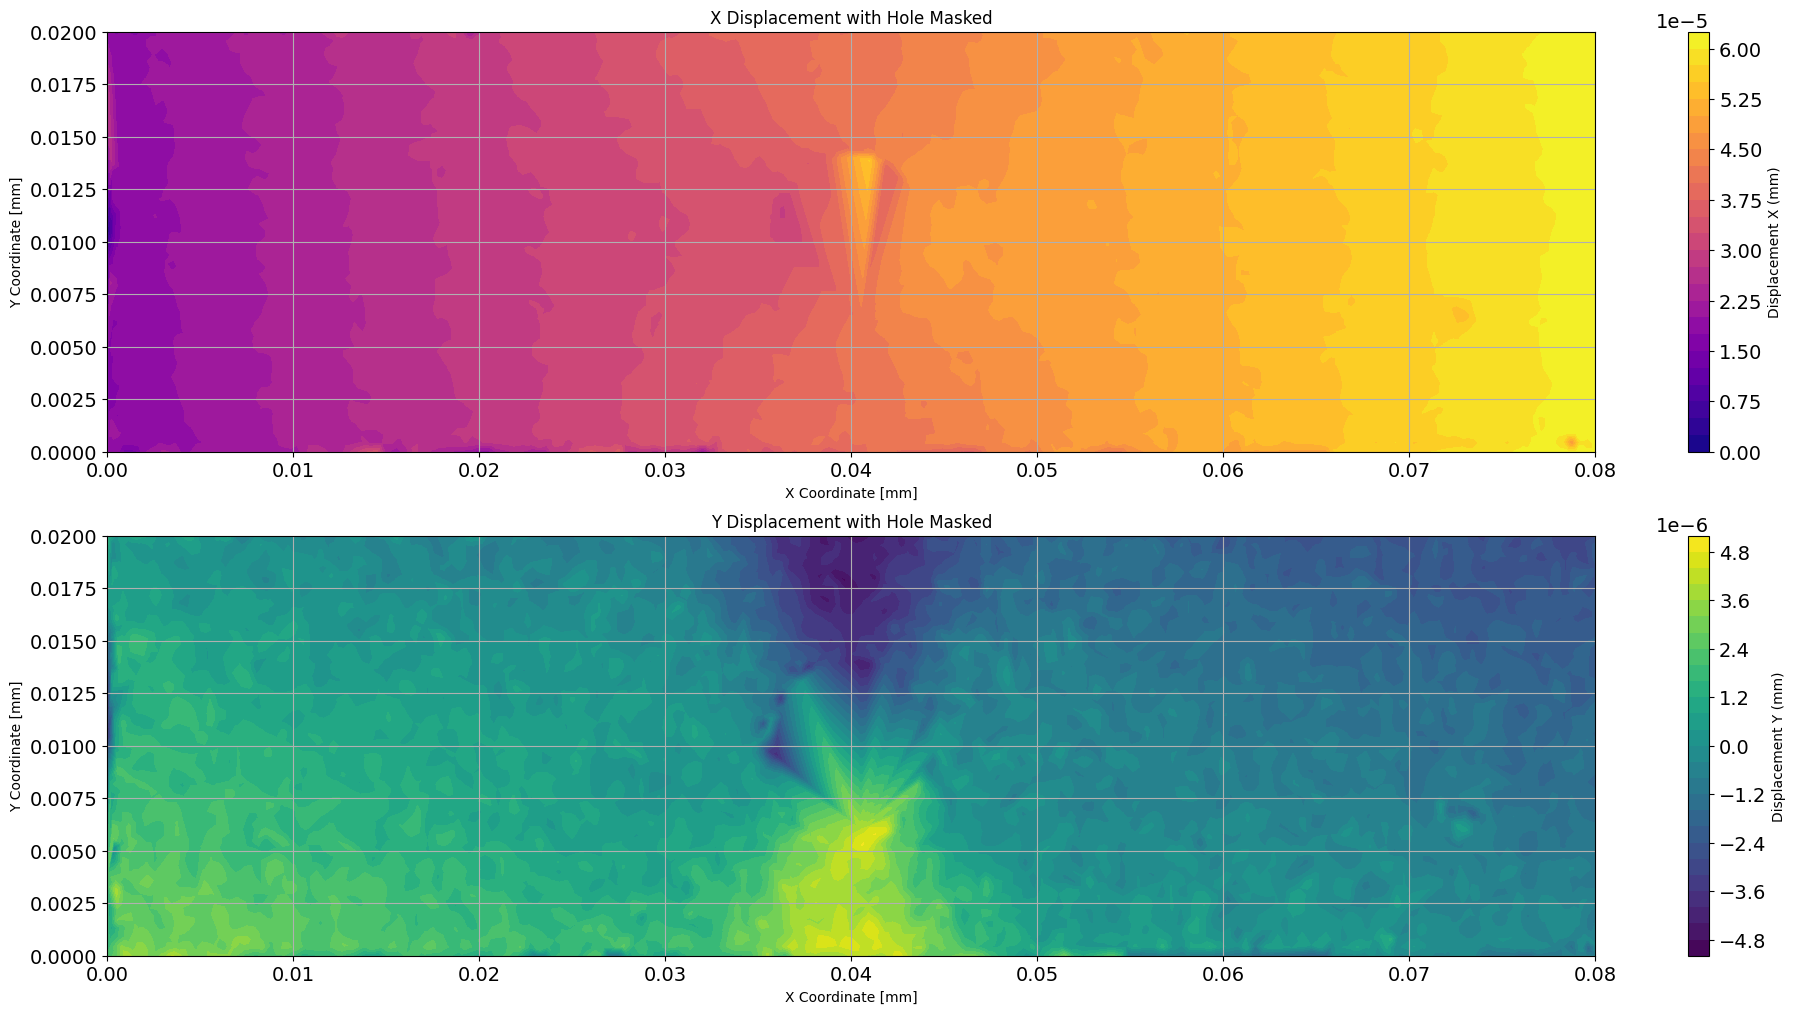

In [25]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
from scipy.interpolate import griddata
raw = True
if raw:
    df = pd.read_csv(r"/mnt/c/Users/bankp/OneDrive/Desktop/ADDMM/dataset/20231116_displacements_raw.csv")
else :
    df = pd.read_csv(r"/mnt/c/Users/bankp/OneDrive/Desktop/ADDMM/dataset/20231116_displacements_interpolated.csv")
def remove_outliers_zscore(df, columns, threshold=3):
    """
    Removes outliers from specified columns in a DataFrame using the Z-score method.

    Parameters:
    - df: DataFrame from which to remove outliers.
    - columns: List of column names to check for outliers.
    - threshold: Z-score threshold to determine outliers (default is 3).

    Returns:
    - Cleaned DataFrame with outliers removed.
    """
    cleaned_df = df.copy()

    for column in columns:
        # Calculate the mean and standard deviation
        mean = cleaned_df[column].mean()
        std = cleaned_df[column].std()

        # Calculate the Z-score for each value in the column
        z_scores = (cleaned_df[column] - mean) / std

        # Filter out outliers based on the Z-score threshold
        cleaned_df = cleaned_df[(np.abs(z_scores) <= threshold)]

    return cleaned_df
def fill_na_with_neighbors(flattened_image, shape):
    rows, cols = shape
    for i in range(1, len(flattened_image) - 1):
        if np.isnan(flattened_image[i]):
            # Get the row and column indices of the pixel in the 2D image
            row = i // cols
            col = i % cols

            # Get the neighbors (left, right, top, bottom) in the flattened array
            neighbors = []
            if col > 0:  # Left neighbor
                neighbors.append(flattened_image[i - 1])
            if col < cols - 1:  # Right neighbor
                neighbors.append(flattened_image[i + 1])
            if row > 0:  # Top neighbor
                neighbors.append(flattened_image[i - cols])
            if row < rows - 1:  # Bottom neighbor
                neighbors.append(flattened_image[i + cols])

            # Remove NaN values from the neighbors list
            neighbors = [val for val in neighbors if not np.isnan(val)]

            # If there are valid neighbors, replace the NaN with the mean
            if neighbors:
                flattened_image[i] = np.mean(neighbors)
    
    return flattened_image

def mask_hole(X, Y) :
    center_x, center_y = 40e-3, 10e-3
    radius = 4e-3

    # Calculate the distance of each point from the center of the circle
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

    # Create a mask: True for points outside the circle, False for points inside
    return distance_from_center >= radius
def get_displacement_at_point(df, x, y, isClearOutlier):
    """
    Interpolates displacement data at a specified (x, y) point.

    Parameters:
    - df: DataFrame with columns ['x', 'y', 'displacement_x', 'displacement_y'].
    - x: float, x-coordinate of the point to interpolate.
    - y: float, y-coordinate of the point to interpolate.
    - method: Interpolation method (default is 'linear').

    Returns:
    - interpolated_displacement_x: Interpolated displacement_x value at the specified point.
    - interpolated_displacement_y: Interpolated displacement_y value at the specified point.
    """
    if isClearOutlier :
        df = remove_outliers_zscore(df, ['x-displacement [mm]', "y-displacement [mm]"], 3)
    # Extract points and displacement values from the DataFrame
    points = df[['x-coordinate [mm]', 'y-coordinate [mm]']].values/1000
    displacement_x = df['x-displacement [mm]'].values/1000
    displacement_y = df['y-displacement [mm]'].values/1000
    # Create interpolators for displacement_x and displacement_y
    interp_x = fill_na_with_neighbors(griddata(points, displacement_x, (x, y), method='linear'), points.shape)
    interp_y = fill_na_with_neighbors(griddata(points, displacement_y, (x, y), method='linear'), points.shape)
    return interp_x, interp_y
X, Y = node_coordinates[:, 0], node_coordinates[:, 1]
mask = mask_hole(X, Y)
Z_x = get_displacement_at_point(df, X, Y, True)[0]
Z_y = get_displacement_at_point(df, X, Y, True)[1]
X_train, Y_train =  np.where(mask, X, np.nan), np.where(mask, Y, np.nan)
Z_x_train = np.where(mask, Z_x, np.nan)
Z_y_train = np.where(mask, Z_y, np.nan)
# # Plotting the mesh
fig, ax = plt.subplots(2, 1, figsize=(24, 12))
print(np.max(Z_x))
# # # Subplot for displacement_x
contour_x = ax[0].tricontourf(X, Y , Z_x , levels=25, cmap='plasma')
cbar_x = fig.colorbar(contour_x, ax=ax[0], label='Displacement X (mm)')
ax[0].set_title('X Displacement with Hole Masked')
ax[0].set_xlabel('X Coordinate [mm]')
ax[0].set_ylabel('Y Coordinate [mm]')
ax[0].grid(True)

# Subplot for Y displacement
contour_y = ax[1].tricontourf(X, Y , Z_y, levels=25, cmap='viridis')
cbar_y = fig.colorbar(contour_y, ax=ax[1], label='Displacement Y (mm)')
ax[1].set_title('Y Displacement with Hole Masked')
ax[1].set_xlabel('X Coordinate [mm]')
ax[1].set_ylabel('Y Coordinate [mm]')
ax[1].grid(True)
# Display the plots
plt.show()

In [5]:
from scipy.optimize import minimize
def callback(xk):
    print(f"Current solution: {xk}")

class OptimizationHistory:
    def __init__(self):
        self.history = []

    def __call__(self, xk):
        # Save current parameter values
        self.history.append(xk.copy())
def mse_loss(domain, facet_tags, train_ds, BETA) :
    G, K = BETA
    _,_,subdomain,subsol = FEM_Solution(domain, facet_tags, G, K)
    radius = 4e-3 
    center_x, center_y = 40e-3, 10e-3
    distance_from_center = np.sqrt((subdomain[:, 0] - center_x)**2 + (subdomain[:, 1] - center_y)**2)
    distance_from_center_train = np.sqrt((train_ds[:, 0] - center_x)**2 + (train_ds[:, 1] - center_y)**2)
    train_disp_x = train_ds[:, 2][distance_from_center_train >= radius]
    train_disp_y = train_ds[:, 3][distance_from_center_train >= radius]
    fem_disp_x = subsol[:, 0][distance_from_center >= radius]
    fem_disp_y = subsol[:, 1][distance_from_center >= radius]
    mean_disp_x = np.mean(np.absolute(train_disp_x))
    mean_disp_y = np.mean(np.absolute(train_disp_y))
    Wx = 1/mean_disp_x
    Wy = 1/mean_disp_y
    err_norm_ux = np.linalg.norm(Wx * (train_disp_x - fem_disp_x))
    err_norm_uy = np.linalg.norm(Wy * (train_disp_y - fem_disp_y))
    result = (err_norm_ux**2 + err_norm_uy**2) * 0.5
    print(err_norm_ux, err_norm_uy) 
    print(BETA, result) 
    return result
history = OptimizationHistory()
# Define constraint as a dictionary
train_ds = np.hstack((X.reshape(X.shape[0], 1), Y.reshape(Y.shape[0], 1), Z_x.reshape(Z_x.shape[0], 1), Z_y.reshape(Z_y.shape[0], 1)))
beta = [1e+9, 1e+9]
result = minimize(
    fun=lambda x: mse_loss(domain, facet_tags, train_ds, x),
    x0=beta,
    method='L-BFGS-B',
    options={'gtol': 1e-9, 'maxiter': 1000},
    callback=history
)

6784.984640775644 5512.634159452035
[1.e+09 1.e+09] 38212575.975759424
6784.984572224514 5512.634036691376
[1.00000001e+09 1.00000000e+09] 38212574.83390646
6784.9846068695115 5512.634198840421
[1.00000000e+09 1.00000001e+09] 38212575.962840594
6784.984636153189 5512.634151251606
[1.e+09 1.e+09] 38212575.89919017
6784.9845675994875 5512.634028492285
[1.00000002e+09 1.00000000e+09] 38212574.75732715
6784.98460224464 5512.634190632086
[1.00000000e+09 1.00000001e+09] 38212575.886211365
6784.984617651223 5512.6341184258345
[1.e+09 1.e+09] 38212575.59269814
6784.984549095019 5512.633995659098
[1.00000002e+09 1.00000000e+09] 38212574.45077727
6784.984583740385 5512.6341578068
[1.00000000e+09 1.00000001e+09] 38212575.57970649
6784.984543631031 5512.63398708667
[1.00000002e+09 1.00000000e+09] 38212574.36644753
6784.984475083705 5512.633864335213
[1.00000004e+09 1.00000000e+09] 38212573.22467114
6784.98450972713 5512.634026478511
[1.00000002e+09 1.00000002e+09] 38212574.35356289
6784.9842475762

In [6]:
result

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 2403.04466396545
        x: [ 7.224e+10  9.169e+10]
      nit: 28
      jac: [-6.968e-10  7.563e-10]
     nfev: 126
     njev: 42
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [38]:
G_cal, K_cal = result.x
domain_cal, deformation_cal, sub_domain, sub_deformation_cal = FEM_Solution(domain, facet_tags, G_cal, K_cal)

6.405245025162028e-05
1.0859501185619989e-05


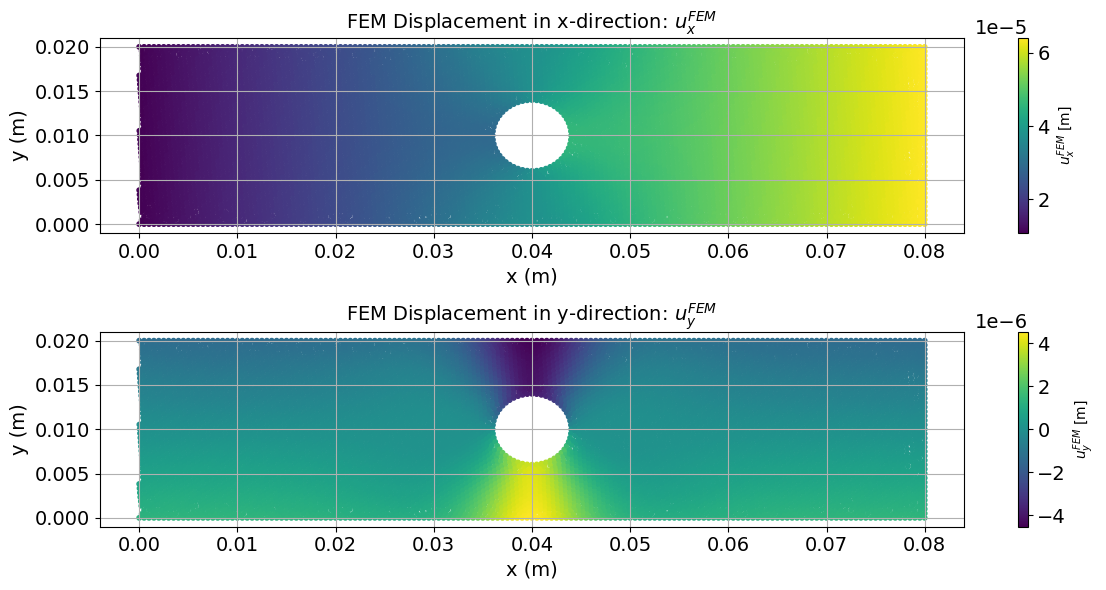

In [39]:
df_solution = pd.DataFrame({"x": sub_domain[:, 0], "y": sub_domain[:, 1], "z_x": sub_deformation_cal[:, 0], "z_y": sub_deformation_cal[:, 1]})
X, Y = sub_domain[:, 0], sub_domain[:, 1]
mask = mask_hole(X, Y)
Z_x = get_displacement_at_point(df, X, Y, True)[0]
Z_y = get_displacement_at_point(df, X, Y, True)[1]
error_field_ux = np.abs(Z_x - sub_deformation_cal[:, 0])
error_field_uy = np.abs(Z_y - sub_deformation_cal[:, 1])
fig, ax = plt.subplots(2, 1, figsize=(12, 6))  # 1 row, 2 columns
print(max(df_solution["z_x"]))
print(min(df_solution["z_x"]))
# First subplot: Scatter plot for y-displacement
scatter1 = ax[0].scatter(df_solution["x"], df_solution["y"], 
                         s=10, c=df_solution["z_x"], cmap='viridis')
fig.colorbar(scatter1, ax=ax[0], label='$u^{FEM}_x$ [m]')
ax[0].set_title('FEM Displacement in x-direction: $u^{FEM}_x$', fontsize=14)
ax[0].set_xlabel('x (m)', fontsize=14)
ax[0].set_ylabel('y (m)', fontsize=14)
ax[0].grid(True)

# Second subplot: Scatter plot for x-displacement
scatter2 = ax[1].scatter(df_solution["x"], df_solution["y"], 
                         s=10, c=df_solution["z_y"], cmap='viridis')
fig.colorbar(scatter2, ax=ax[1], label='$u^{FEM}_y$ [m]')
ax[1].set_title('FEM Displacement in y-direction: $u^{FEM}_y$', fontsize=14)
ax[1].set_xlabel('x (m)', fontsize=14)
ax[1].set_ylabel('y (m)', fontsize=14)
ax[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()
pp = PdfPages('disp_field.pdf')
pp.savefig(fig)
pp.close()

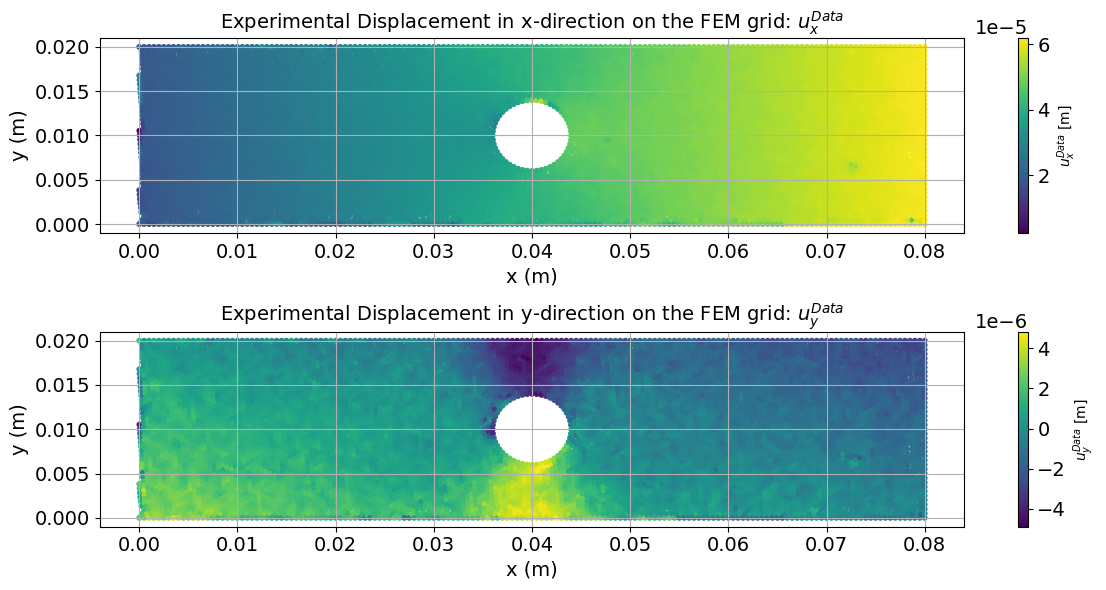

In [40]:
X, Y = sub_domain[:, 0], sub_domain[:, 1]
Z_x = get_displacement_at_point(df, X, Y, True)[0]
Z_y = get_displacement_at_point(df, X, Y, True)[1]
fig, ax = plt.subplots(2, 1, figsize=(12, 6))  # 1 row, 2 columns
# First subplot: Scatter plot for y-displacement
scatter1 = ax[0].scatter(df_solution["x"], df_solution["y"], 
                         s=10, c=Z_x, cmap='viridis')
fig.colorbar(scatter1, ax=ax[0], label='$u^{Data}_x$ [m]')
ax[0].set_title('Experimental Displacement in x-direction on the FEM grid: $u^{Data}_x$', fontsize=14)
ax[0].set_xlabel('x (m)', fontsize=14)
ax[0].set_ylabel('y (m)', fontsize=14)
ax[0].grid(True)

# Second subplot: Scatter plot for x-displacement
scatter2 = ax[1].scatter(df_solution["x"], df_solution["y"], 
                         s=10, c=Z_y, cmap='viridis')
fig.colorbar(scatter2, ax=ax[1], label='$u^{Data}_y$ [m]')
ax[1].set_title('Experimental Displacement in y-direction on the FEM grid: $u^{Data}_y$', fontsize=14)
ax[1].set_xlabel('x (m)', fontsize=14)
ax[1].set_ylabel('y (m)', fontsize=14)
ax[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()

pp = PdfPages('exp_data.pdf')
pp.savefig(fig)
pp.close()

1.640573078355629e-05 5.63819888360303e-10 3.5606899305896698e-06
4.17321217620092e-06 7.56198810775901e-10 8.500862919383435e-07


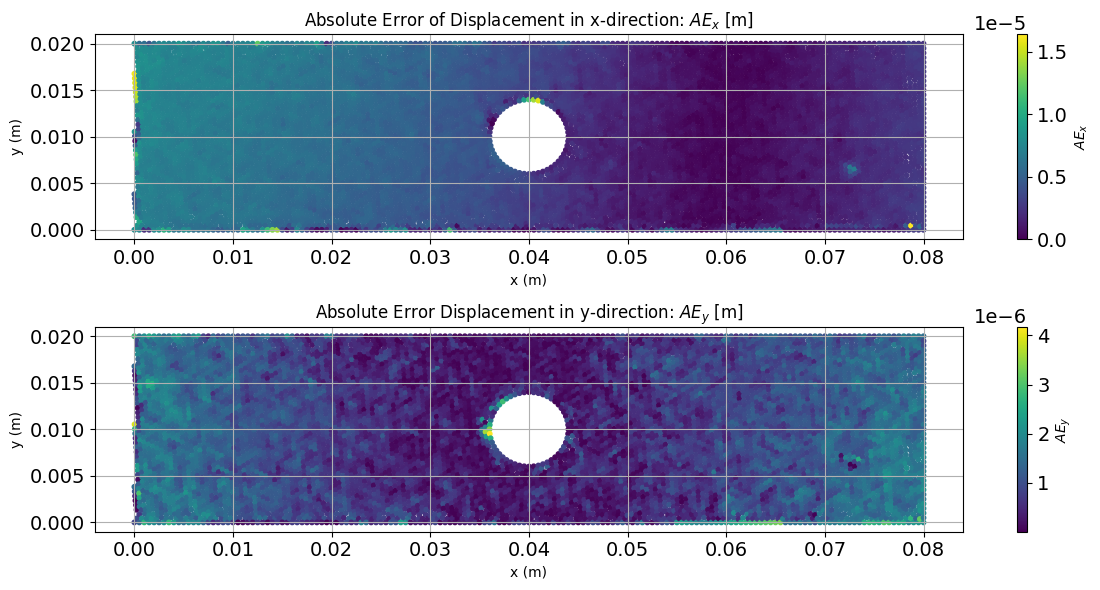

In [44]:
df_solution = pd.DataFrame({"x": sub_domain[:, 0], "y": sub_domain[:, 1], "z_x": sub_deformation_cal[:, 0], "z_y": sub_deformation_cal[:, 1]})
X, Y = sub_domain[:, 0], sub_domain[:, 1]
mask = mask_hole(X, Y)
Z_x = get_displacement_at_point(df, X, Y, True)[0]
Z_y = get_displacement_at_point(df, X, Y, True)[1]
error_field_ux = np.abs(Z_x - sub_deformation_cal[:, 0])
error_field_uy = np.abs(Z_y - sub_deformation_cal[:, 1])
fig, ax = plt.subplots(2, 1, figsize=(12, 6))  # 1 row, 2 columns
print(max(error_field_ux), min(error_field_ux), np.mean(error_field_ux))
print(max(error_field_uy), min(error_field_uy), np.mean(error_field_uy))

scatter3 = ax[0].scatter(df_solution["x"], df_solution["y"], 
                         s=10, c=error_field_ux, cmap='viridis', vmin =0)
fig.colorbar(scatter3, ax=ax[0], label='$AE_x$')
ax[0].set_title('Absolute Error of Displacement in x-direction: $AE_x$ [m]')
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('y (m)')
ax[0].grid(True)

scatter4 = ax[1].scatter(df_solution["x"], df_solution["y"], 
                         s=10, c=error_field_uy, cmap='viridis')
fig.colorbar(scatter4, ax=ax[1], label='$AE_y$')
ax[1].set_title('Absolute Error Displacement in y-direction: $AE_y$ [m]')
ax[1].set_xlabel('x (m)')
ax[1].set_ylabel('y (m)')
ax[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()
pp = PdfPages('error_field.pdf')
pp.savefig(fig)
pp.close()

In [42]:
with io.XDMFFile(domain_cal.comm, "deformation_cal_narunat.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain_cal)
    deformation_cal.name = "Deformation"
    xdmf.write_function(deformation_cal)

In [1]:
def add(x,y) :
    return x+y

In [2]:
lambda_add = lambda x,y : x+y

In [3]:
add(10,5)

15

In [4]:
lambda_add(10,5)

15